C:\Users\pc_of_han\AppData\Local\Temp\ipykernel_9328\2440814951.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Month'] = pd.to_datetime(df['Date']).dt.month


训练 线性回归 模型...
线性回归 模型评估结果:
  训练集 MSE: 1189.3772
  测试集 MSE: 1253.4090
  训练集 MAE: 22.7254
  测试集 MAE: 23.0178
  训练集 R²: 0.8380
  测试集 R²: 0.8421

训练 岭回归 模型...
岭回归 模型评估结果:
  训练集 MSE: 1208.4402
  测试集 MSE: 1345.5591
  训练集 MAE: 22.6666
  测试集 MAE: 23.6769
  训练集 R²: 0.8354
  测试集 R²: 0.8305

训练 Lasso回归 模型...
Lasso回归 模型评估结果:
  训练集 MSE: 1263.0159
  测试集 MSE: 1497.7652
  训练集 MAE: 23.2767
  测试集 MAE: 24.5537
  训练集 R²: 0.8279
  测试集 R²: 0.8113

训练 K近邻 模型...
K近邻 模型评估结果:
  训练集 MSE: 611.8153
  测试集 MSE: 1200.3017
  训练集 MAE: 9.6316
  测试集 MAE: 12.3379
  训练集 R²: 0.9167
  测试集 R²: 0.8488

训练 支持向量机 模型...
支持向量机 模型评估结果:
  训练集 MSE: 1783.2934
  测试集 MSE: 2211.8123
  训练集 MAE: 21.8210
  测试集 MAE: 23.3546
  训练集 R²: 0.7571
  测试集 R²: 0.7213

训练 随机森林 模型...
随机森林 模型评估结果:
  训练集 MSE: 109.9960
  测试集 MSE: 321.7248
  训练集 MAE: 3.5602
  测试集 MAE: 6.9268
  训练集 R²: 0.9850
  测试集 R²: 0.9595



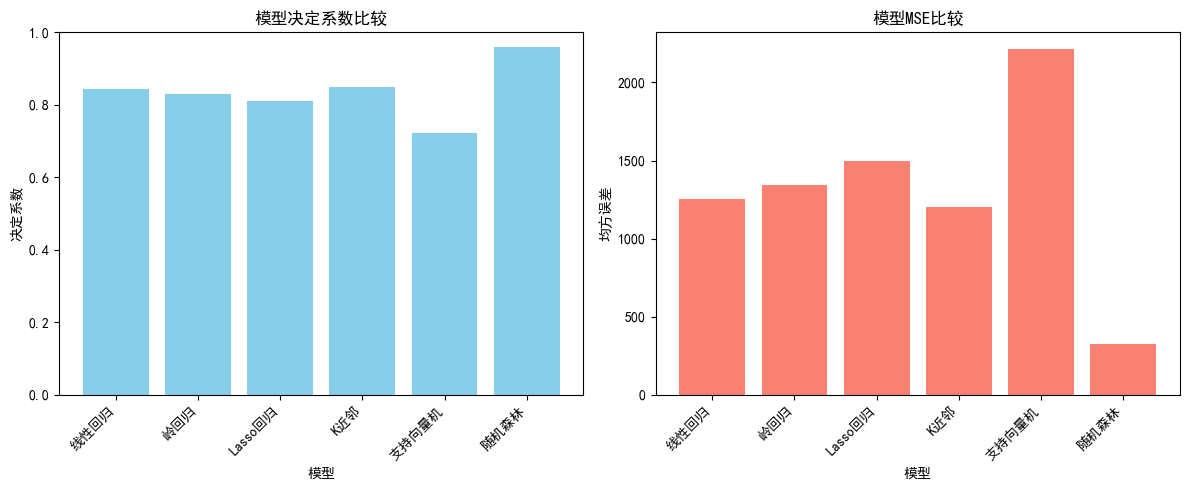

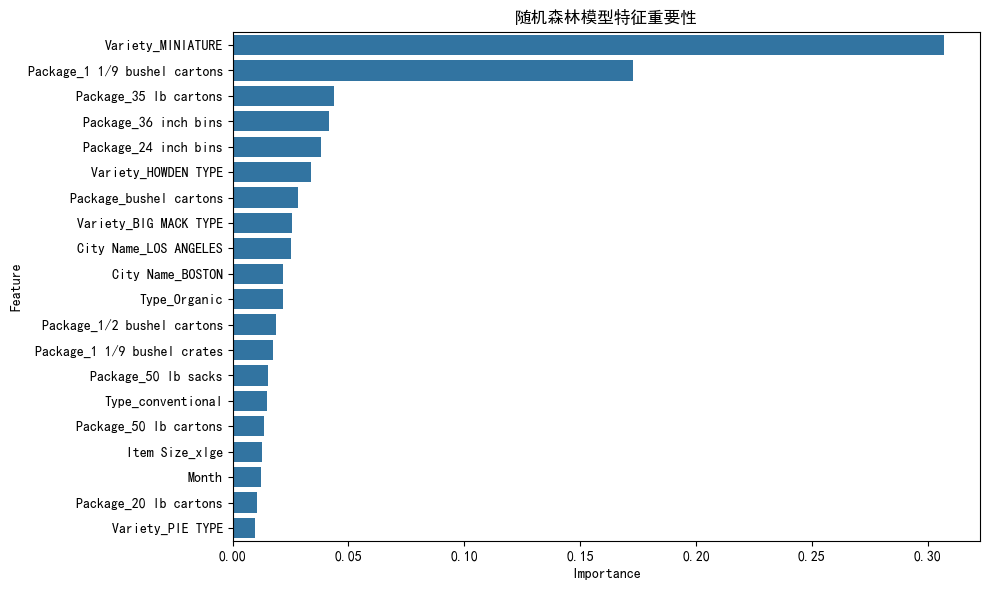

In [8]:
import pandas as pd
import numpy as np
from sklearn.covariance import EmpiricalCovariance
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文显示
plt.rcParams['font.family'] = 'SimHei'

# 加载数据集
df = pd.read_csv('US-pumpkins.csv')

# 数据预处理
def preprocess_data(df):
    # 提取月份特征
    df['Month'] = pd.to_datetime(df['Date']).dt.month
    
    # 计算平均价格作为目标变量
    df['Average Price'] = (df['Low Price'] + df['High Price']) / 2
    
    # 处理缺失值
    df['Type'] = df['Type'].fillna('conventional')  # 填充Type缺失值
    df['Item Size'] = df['Item Size'].fillna('med')  # 填充Item Size缺失值
    
    # 移除缺失值较多的列
    df = df.drop(['Grade', 'Environment', 'Unit of Sale', 'Quality', 
                  'Condition', 'Appearance', 'Storage', 'Crop', 
                  'Trans Mode', 'Unnamed: 24', 'Unnamed: 25'], axis=1)
    
    # 移除价格相关列，避免数据泄露
    df = df.drop(['Low Price', 'High Price', 'Mostly Low', 'Mostly High'], axis=1)
    
    # 移除未使用的分类列
    df = df.drop(['Sub Variety', 'Origin District', 'Repack'], axis=1)
    
    return df

# 特征工程
def engineer_features(df):
    # 定义数值特征和分类特征
    numerical_features = ['Month']
    categorical_features = ['City Name', 'Type', 'Package', 'Variety', 
                            'Origin', 'Item Size', 'Color']
    
    # 创建特征转换管道
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    return preprocessor, numerical_features, categorical_features

# 模型评估
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # 在训练集和测试集上进行预测
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 计算评估指标
    metrics = {
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'test_mse': mean_squared_error(y_test, y_test_pred),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred)
    }
    
    return metrics

# 主函数
def main():
    # 数据预处理
    df_processed = preprocess_data(df)
    
    # 特征工程
    preprocessor, numerical_features, categorical_features = engineer_features(df_processed)
    
    # 准备特征和目标变量
    X = df_processed.drop('Average Price', axis=1)
    y = df_processed['Average Price']
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 定义要评估的模型
    models = {
        '线性回归': Pipeline(steps=[('preprocessor', preprocessor),
                                  ('regressor', LinearRegression())]),
        '岭回归': Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', Ridge(alpha=1.0))]),
        'Lasso回归': Pipeline(steps=[('preprocessor', preprocessor),
                                  ('regressor', Lasso(alpha=0.1))]),
        'K近邻': Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', KNeighborsRegressor(n_neighbors=5))]),
        '支持向量机': Pipeline(steps=[('preprocessor', preprocessor),
                                  ('regressor', SVR(kernel='rbf', C=10, gamma=0.1))]),
        '随机森林': Pipeline(steps=[('preprocessor', preprocessor),
                                  ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])
    }
    
    # 存储模型评估结果
    results = {}
    
    # 训练和评估模型
    for name, model in models.items():
        print(f"训练 {name} 模型...")
        model.fit(X_train, y_train)
        metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
        results[name] = metrics
        
        print(f"{name} 模型评估结果:")
        print(f"  训练集 MSE: {metrics['train_mse']:.4f}")
        print(f"  测试集 MSE: {metrics['test_mse']:.4f}")
        print(f"  训练集 MAE: {metrics['train_mae']:.4f}")
        print(f"  测试集 MAE: {metrics['test_mae']:.4f}")
        print(f"  训练集 R²: {metrics['train_r2']:.4f}")
        print(f"  测试集 R²: {metrics['test_r2']:.4f}")
        print()
    
    # 可视化模型比较
    plot_model_comparison(results)
    
    # 特征重要性分析（以随机森林为例）
    plot_feature_importance(models['随机森林'], numerical_features, categorical_features)

# 可视化模型比较
def plot_model_comparison(results):
    model_names = list(results.keys())
    test_r2 = [results[name]['test_r2'] for name in model_names]
    test_mse = [results[name]['test_mse'] for name in model_names]
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.bar(model_names, test_r2, color='skyblue')
    plt.ylim(0, 1)
    plt.title('模型决定系数比较')
    plt.xlabel('模型')
    plt.ylabel('决定系数')
    plt.xticks(rotation=45, ha='right')
    
    plt.subplot(1, 2, 2)
    plt.bar(model_names, test_mse, color='salmon')
    plt.title('模型MSE比较')
    plt.xlabel('模型')
    plt.ylabel('均方误差')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

# 可视化特征重要性
def plot_feature_importance(model, numerical_features, categorical_features):
    # 获取随机森林模型
    rf_model = model.named_steps['regressor']
    
    # 获取特征重要性
    feature_importance = rf_model.feature_importances_
    
    # 获取特征名称
    encoder = model.named_steps['preprocessor'].named_transformers_['cat']
    onehot_features = list(encoder.get_feature_names_out(categorical_features))
    all_features = numerical_features + onehot_features
    
    # 创建特征重要性DataFrame
    importance_df = pd.DataFrame({
        'Feature': all_features,
        'Importance': feature_importance
    })
    
    # 选择最重要的20个特征
    top_features = importance_df.sort_values('Importance', ascending=False).head(20)
    
    # 可视化特征重要性
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('随机森林模型特征重要性')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

if __name__ == "__main__":
    main()    


### 数值特征协方差分析 ###
                   Month      Year  Average Price
Month           1.219547 -0.274528     -13.288549
Year           -0.274528  0.197674       3.383634
Average Price -13.288549  3.383634    7465.287757
涉及特征：['Month', 'Year', 'Average Price']

===== 训练 线性回归 模型 =====
  训练集 MSE: 1297.1808
  测试集 MSE: 1467.8171
  训练集 MAE: 23.7003
  测试集 MAE: 24.6428
  训练集 决定系数: 0.8233
  测试集 决定系数: 0.8150


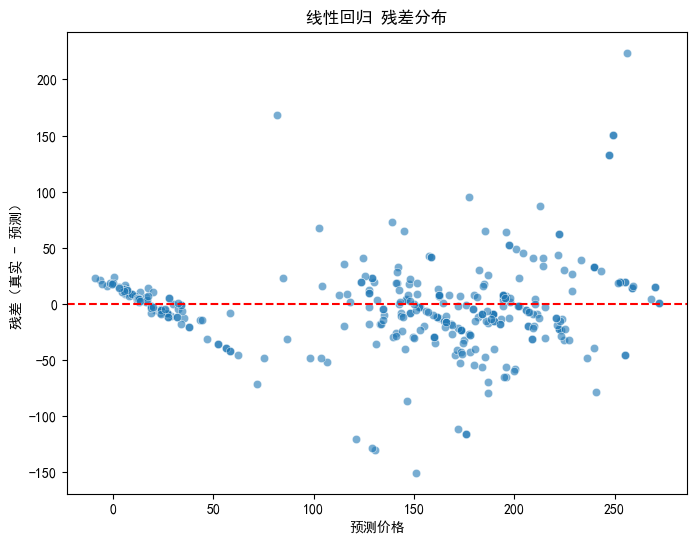

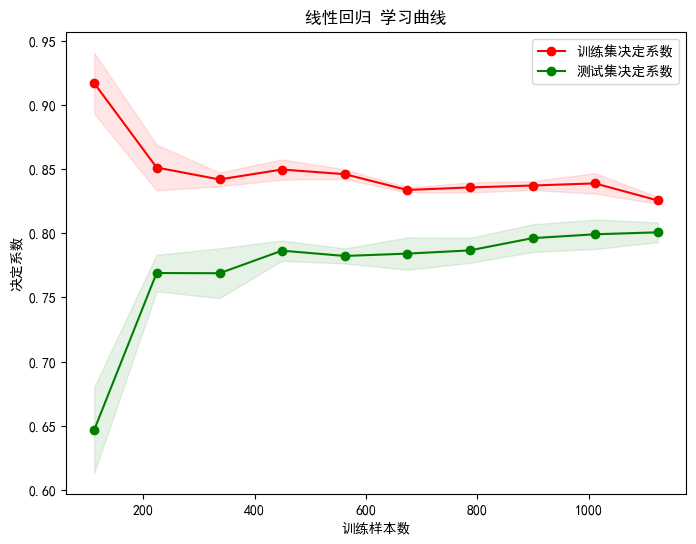


===== 训练 岭回归 模型 =====
  最佳参数：{'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
  训练集 MSE: 1297.3380
  测试集 MSE: 1473.6078
  训练集 MAE: 23.6450
  测试集 MAE: 24.6402
  训练集 决定系数: 0.8233
  测试集 决定系数: 0.8143


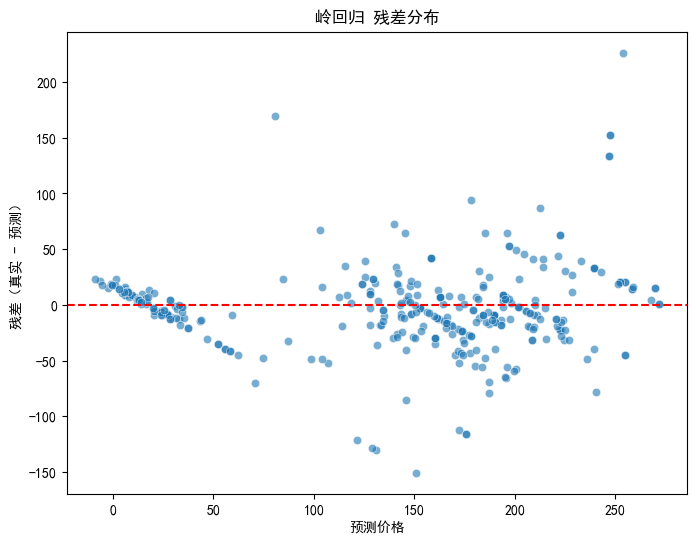

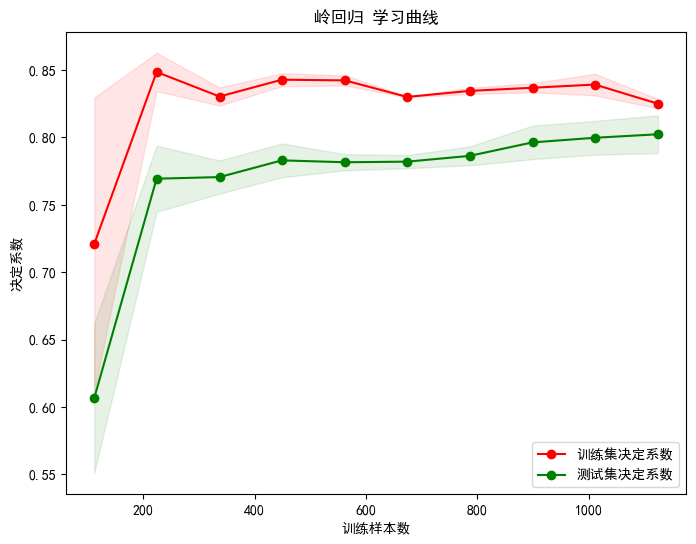


===== 训练 Lasso回归 模型 =====
  最佳参数：{'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
  训练集 MSE: 1298.1083
  测试集 MSE: 1478.4372
  训练集 MAE: 23.5986
  测试集 MAE: 24.6426
  训练集 决定系数: 0.8232
  测试集 决定系数: 0.8137


C:\Users\pc_of_han\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79791.20175147848, tolerance: 1031.3316612386116
  model = cd_fast.sparse_enet_coordinate_descent(


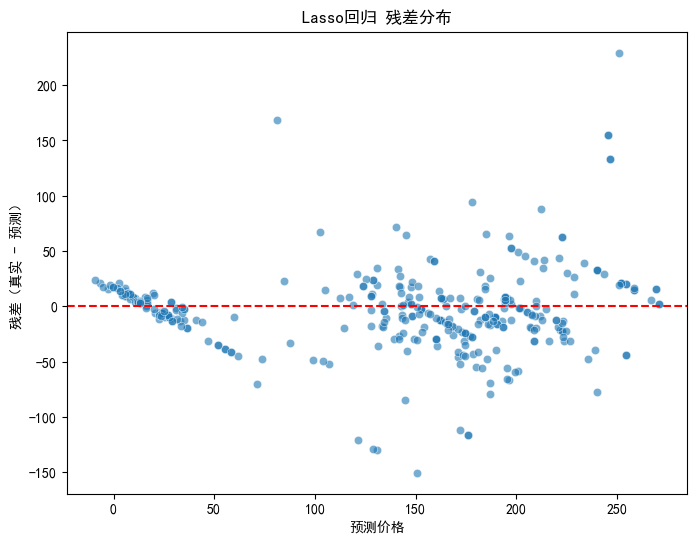

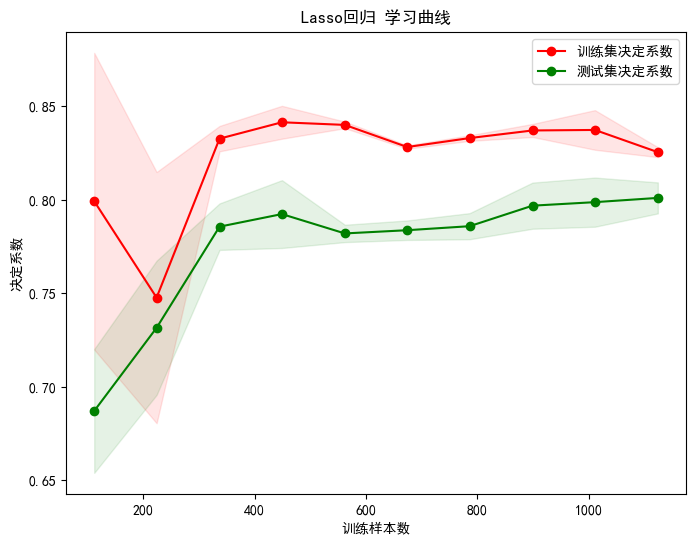


===== 训练 K近邻 模型 =====
  最佳参数：{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
  训练集 MSE: 189.0380
  测试集 MSE: 221.5352
  训练集 MAE: 2.8993
  测试集 MAE: 4.7731
  训练集 决定系数: 0.9742
  测试集 决定系数: 0.9721


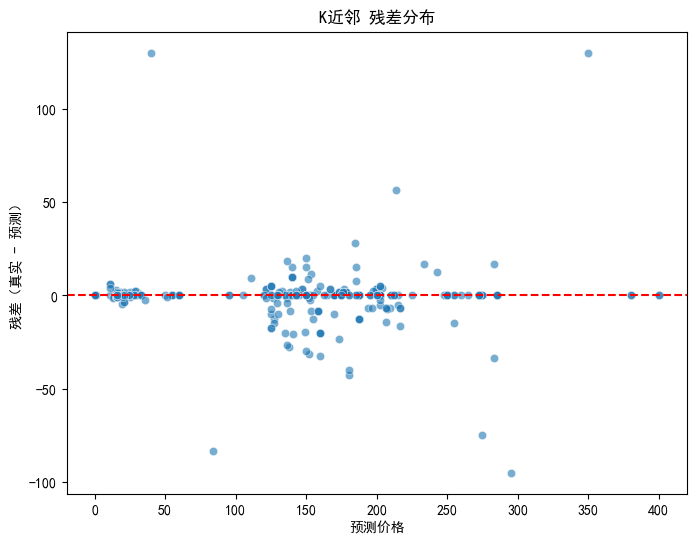

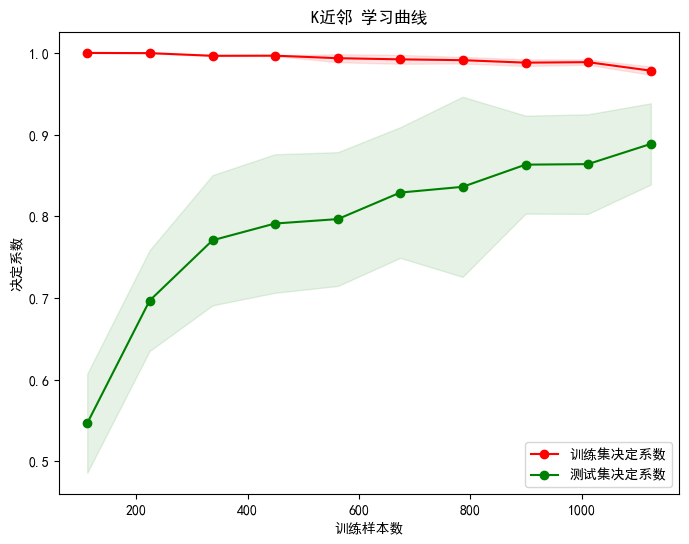


===== 训练 支持向量机 模型 =====
  最佳参数：{'C': 100, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
  训练集 MSE: 635.1481
  测试集 MSE: 964.8016
  训练集 MAE: 7.7053
  测试集 MAE: 10.5155
  训练集 决定系数: 0.9135
  测试集 决定系数: 0.8784


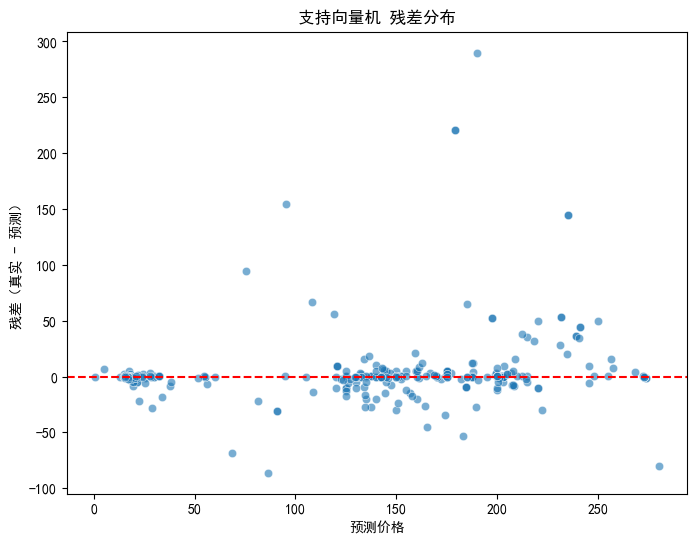

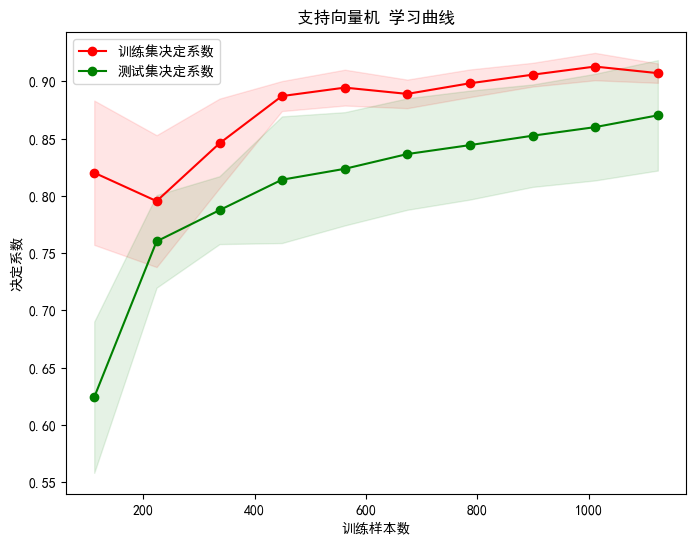


===== 训练 随机森林 模型 =====
  最佳参数：{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
  训练集 MSE: 197.9635
  测试集 MSE: 328.0118
  训练集 MAE: 4.2842
  测试集 MAE: 6.8055
  训练集 决定系数: 0.9730
  测试集 决定系数: 0.9587


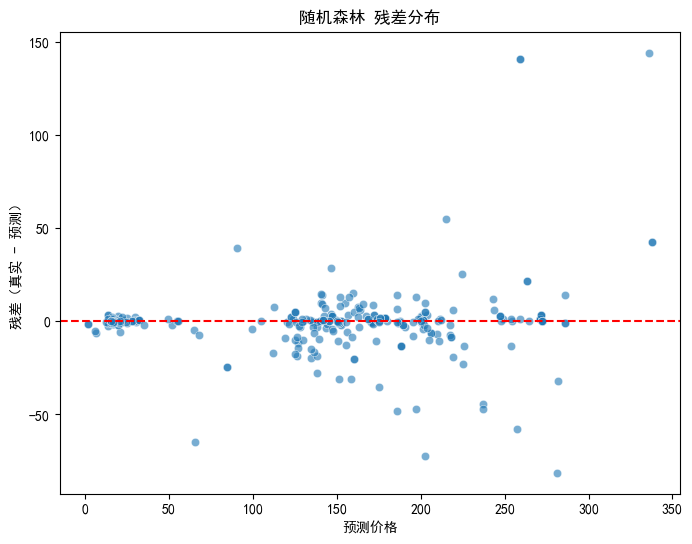

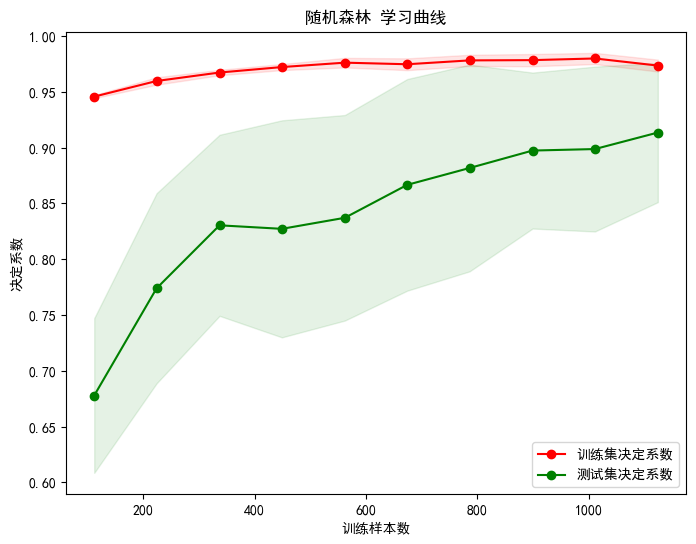


===== 训练 XGBoost 模型 =====
  最佳参数：{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
  训练集 MSE: 417.3797
  测试集 MSE: 514.9730
  训练集 M

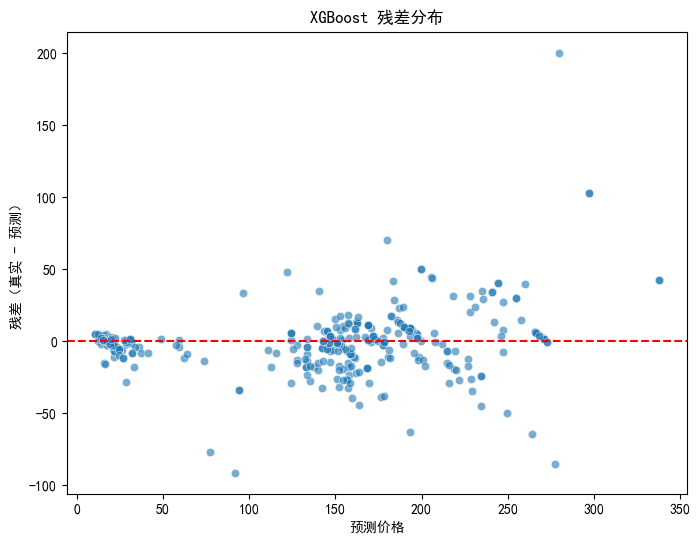

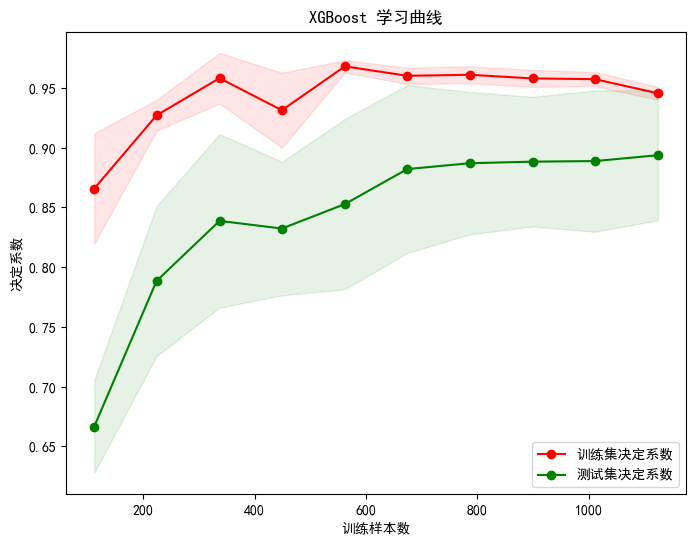

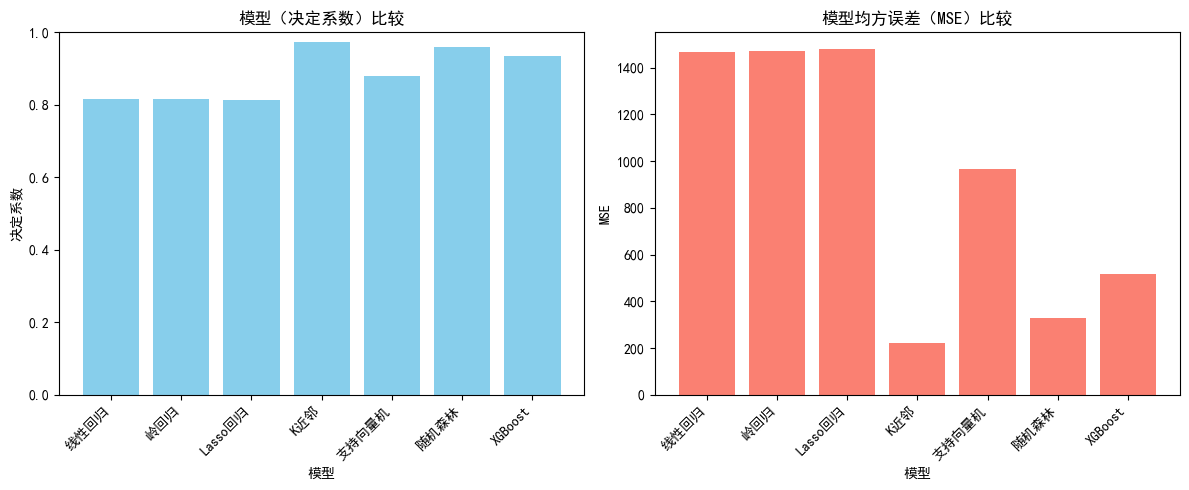

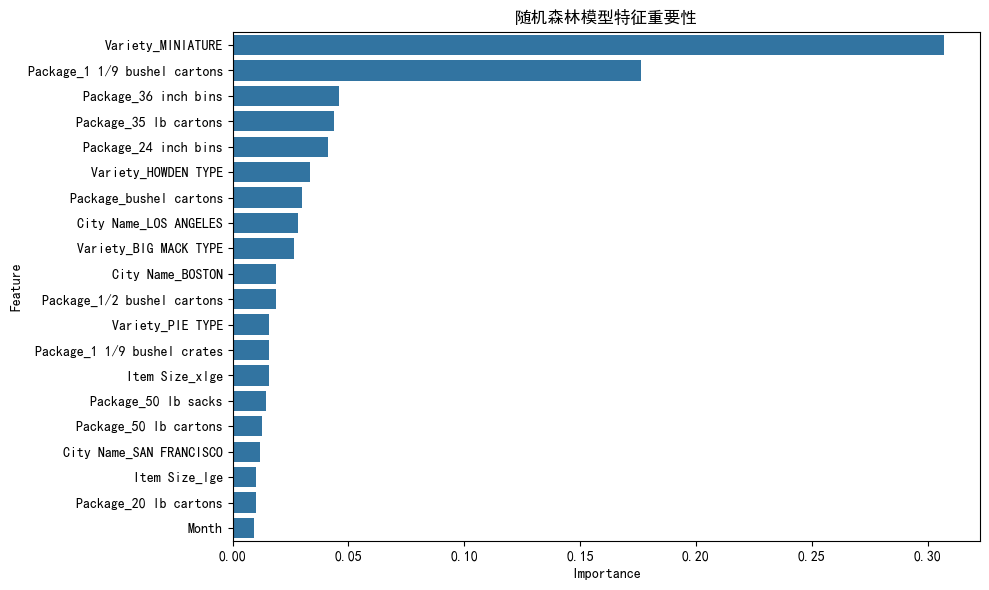

In [10]:
import pandas as pd
import numpy as np
from sklearn.covariance import EmpiricalCovariance
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文显示
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# ----------------------
# 1. 数据预处理函数优化
# ----------------------
def preprocess_data(df):
    """
    1. 日期解析：指定格式，处理异常值
    2. 缺失值填充：针对所有分类列
    3. 高基数类别处理：合并稀有类别
    4. 特征衍生：年份、季节
    5. 冗余列删除
    """
    # 日期解析（指定格式，处理异常值）
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y', errors='coerce')
    df = df.dropna(subset=['Date'])  # 删除日期解析失败的行
    
    # 衍生时间特征
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Season'] = df['Month'].apply(
        lambda x: 'Spring' if 3<=x<=5 else 
        'Summer' if 6<=x<=8 else 
        'Autumn' if 9<=x<=11 else 'Winter'
    )
    
    # 计算目标变量（平均价格）
    df['Average Price'] = (df['Low Price'] + df['High Price']) / 2
    
    # 缺失值填充（众数填充分类列）
    for col in ['Type', 'Item Size', 'Color']:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    # 高基数类别处理（保留前10个常见类别，其余归为Other）
    for col in ['City Name', 'Origin']:
        top_10_cats = df[col].value_counts().head(10).index
        df[col] = df[col].apply(lambda x: x if x in top_10_cats else 'Other')
    
    # 删除冗余列
    drop_cols = [
        'Grade', 'Environment', 'Unit of Sale', 'Quality', 
        'Condition', 'Appearance', 'Storage', 'Crop', 
        'Trans Mode', 'Unnamed: 24', 'Unnamed: 25',
        'Low Price', 'High Price', 'Mostly Low', 'Mostly High',
        'Sub Variety', 'Origin District', 'Repack'
    ]
    df = df.drop(drop_cols, axis=1)
    
    return df

# ----------------------
# 2. 特征工程函数优化
# ----------------------
def engineer_features(df):
    """
    定义数值特征和分类特征，构建预处理管道：
    - 数值特征：标准化
    - 分类特征：独热编码（处理未知类别）
    """
    numerical_features = ['Month', 'Year']  # 新增Year特征
    categorical_features = [
        'City Name', 'Type', 'Package', 'Variety', 
        'Origin', 'Item Size', 'Color', 'Season'  # 新增Season特征
    ]
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    return preprocessor, numerical_features, categorical_features

# ----------------------
# 3. 模型评估函数优化
# ----------------------
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    计算MSE、MAE、决定系数，支持交叉验证结果展示
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    metrics = {
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'test_mse': mean_squared_error(y_test, y_test_pred),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred)
    }
    return metrics

# ----------------------
# 4. 可视化函数扩展
# ----------------------
def plot_model_comparison(results):
    """
    对比不同模型的决定系数和MSE
    """
    model_names = list(results.keys())
    test_r2 = [results[name]['test_r2'] for name in model_names]
    test_mse = [results[name]['test_mse'] for name in model_names]
    
    plt.figure(figsize=(12, 5))
    
    # 子图1：决定系数对比
    plt.subplot(1, 2, 1)
    plt.bar(model_names, test_r2, color='skyblue')
    plt.ylim(0, 1)
    plt.title('模型（决定系数）比较')
    plt.xlabel('模型')
    plt.ylabel('决定系数')
    plt.xticks(rotation=45, ha='right')
    
    # 子图2：MSE对比
    plt.subplot(1, 2, 2)
    plt.bar(model_names, test_mse, color='salmon')
    plt.title('模型均方误差（MSE）比较')
    plt.xlabel('模型')
    plt.ylabel('MSE')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

def plot_residuals(y_true, y_pred, model_name):
    """
    残差图：分析预测偏差
    """
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f'{model_name} 残差分布')
    plt.xlabel('预测价格')
    plt.ylabel('残差（真实 - 预测）')
    plt.savefig(f'{model_name}_residuals.png')
    plt.show()

def plot_learning_curve(model, X, y, model_name):
    """
    学习曲线：分析偏差-方差权衡
    """
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='r2', 
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.fill_between(train_sizes, train_mean - train_std, 
                     train_mean + train_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_mean - test_std, 
                     test_mean + test_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_mean, 'o-', color='r', label='训练集决定系数')
    plt.plot(train_sizes, test_mean, 'o-', color='g', label='测试集决定系数')
    plt.title(f'{model_name} 学习曲线')
    plt.xlabel('训练样本数')
    plt.ylabel('决定系数')
    plt.legend()
    plt.savefig(f'{model_name}_learning_curve.png')
    plt.show()

# 修复后的特征重要性函数
def plot_feature_importance(model, numerical_features, categorical_features):
    """
    随机森林特征重要性可视化
    """
    # 获取实际的随机森林模型（处理GridSearchCV的情况）
    rf_model = model.named_steps['regressor']
    
    # 检查是否使用了GridSearchCV
    if hasattr(rf_model, 'best_estimator_'):
        rf_model = rf_model.best_estimator_
    
    feature_importance = rf_model.feature_importances_
    
    # 获取独热编码后的特征名
    encoder = model.named_steps['preprocessor'].named_transformers_['cat']
    onehot_features = list(encoder.get_feature_names_out(categorical_features))
    all_features = numerical_features + onehot_features
    
    importance_df = pd.DataFrame({
        'Feature': all_features,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False).head(20)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('随机森林模型特征重要性')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

# ----------------------
# 5. 协方差分析（补充探索性分析）
# ----------------------
def analyze_covariance(df):
    """
    数值特征的协方差矩阵分析
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        print("⚠️ 无有效数值特征用于协方差分析")
        return
    
    df_numeric = df[numeric_cols].dropna()
    if df_numeric.empty:
        print("⚠️ 数值特征无有效数据（已删除所有缺失值行）")
        return
    
    cov_estimator = EmpiricalCovariance()
    cov_matrix = cov_estimator.fit(df_numeric).covariance_
    cov_df = pd.DataFrame(cov_matrix, columns=numeric_cols, index=numeric_cols)
    
    print("\n### 数值特征协方差分析 ###")
    print(cov_df)
    print(f"涉及特征：{numeric_cols}")

# ----------------------
# 6. 主函数（整合所有流程）
# ----------------------
def main():
    # 1. 加载并预处理数据
    df = pd.read_csv('US-pumpkins.csv')
    df_processed = preprocess_data(df)
    
    # 2. 协方差探索性分析
    analyze_covariance(df_processed)
    
    # 3. 特征工程
    preprocessor, numerical_features, categorical_features = engineer_features(df_processed)
    
    # 4. 划分数据集
    X = df_processed.drop('Average Price', axis=1)
    y = df_processed['Average Price']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # 5. 定义模型（带网格搜索调优）
    models = {
        '线性回归': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', LinearRegression())
        ]),
        '岭回归': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', GridSearchCV(
                Ridge(), 
                param_grid={'alpha': [0.1, 1, 10]}, 
                cv=5, n_jobs=-1
            ))
        ]),
        'Lasso回归': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', GridSearchCV(
                Lasso(), 
                param_grid={'alpha': [0.01, 0.1, 1]}, 
                cv=5, n_jobs=-1
            ))
        ]),
        'K近邻': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', GridSearchCV(
                KNeighborsRegressor(), 
                param_grid={'n_neighbors': [3,5,7,9], 'weights': ['uniform', 'distance']}, 
                cv=5, n_jobs=-1
            ))
        ]),
        '支持向量机': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', GridSearchCV(
                SVR(), 
                param_grid={'kernel': ['rbf', 'linear'], 'C': [1, 10, 100], 'gamma': [0.01, 0.1, 1]}, 
                cv=5, n_jobs=-1
            ))
        ]),
        '随机森林': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', GridSearchCV(
                RandomForestRegressor(random_state=42), 
                param_grid={'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}, 
                cv=5, n_jobs=-1
            ))
        ]),
        'XGBoost': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', GridSearchCV(
                XGBRegressor(random_state=42), 
                param_grid={'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}, 
                cv=5, n_jobs=-1
            ))
        ])
    }
    
    # 6. 训练、评估、可视化
    results = {}
    for name, model in models.items():
        print(f"\n===== 训练 {name} 模型 =====")
        model.fit(X_train, y_train)
        
        # 获取网格搜索最佳模型（若适用）
        if hasattr(model.named_steps['regressor'], 'best_estimator_'):
            best_regressor = model.named_steps['regressor'].best_estimator_
            model.named_steps['regressor'] = best_regressor
            print(f"  最佳参数：{best_regressor.get_params()}")
        
        # 评估指标
        metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
        results[name] = metrics
        
        # 打印结果
        print(f"  训练集 MSE: {metrics['train_mse']:.4f}")
        print(f"  测试集 MSE: {metrics['test_mse']:.4f}")
        print(f"  训练集 MAE: {metrics['train_mae']:.4f}")
        print(f"  测试集 MAE: {metrics['test_mae']:.4f}")
        print(f"  训练集 决定系数: {metrics['train_r2']:.4f}")
        print(f"  测试集 决定系数: {metrics['test_r2']:.4f}")
        
        # 可视化（残差图 + 学习曲线）
        y_test_pred = model.predict(X_test)
        plot_residuals(y_test, y_test_pred, name)
        plot_learning_curve(model, X_train, y_train, name)
    
    # 模型对比可视化
    plot_model_comparison(results)
    
    # 特征重要性（仅随机森林）
    if '随机森林' in models:
        plot_feature_importance(models['随机森林'], numerical_features, categorical_features)

if __name__ == "__main__":
    main()